Финальная работа FlowPS для нескольких датасетов(для остальных по аналогии). 

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Подключаем возможность работать с языком R в гугл коллаб:

In [ ]:
# activate R magic
%load_ext rpy2.ipython

# GSE20181

Запускаем модифицированный питоновский скрипт(где каждый объект имеет уже свои собственные core markers) и получаем предсказания для каждой пары surround(m) и neighbours(k):

In [ ]:
%%R

system2("python3", c("/content/drive/My\\ Drive/FlowPS/flowps_new.py", 
                     "--train-file", "/content/drive/My\\ Drive/FlowPS/change_data/GSE20181.csv", 
                     "--out-dir", "/content/drive/My\\ Drive/FlowPS/predictions/", 
                     "--features", "/content/drive/My\\ Drive/FlowPS/change_data/features_fin_GSE20181.pickle",
                     "--min-neighbours", 20, "--max-neighbours", 30,
                     "--min-surround", 1, "--max-surround", 8), 
                      stderr = "/content/drive/My Drive/FlowPS/predictions/err.txt")

Посмотрим на получившуюся color map:

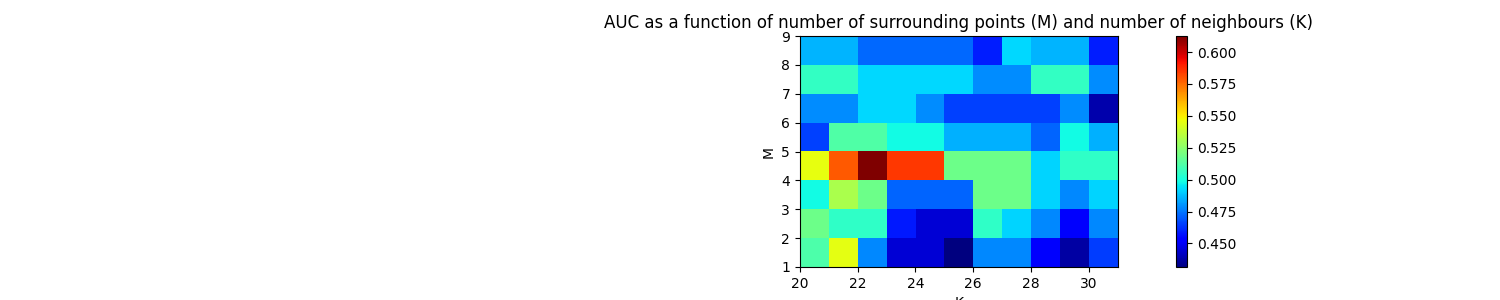

In [ ]:
img = Image.open("/content/drive/My Drive/FlowPS/predictions/auc.png")
img

Посмотрим на предсказания:

In [ ]:
pred = pd.read_csv('/content/drive/My Drive/FlowPS/predictions/predictions.csv', header=None)
print(pred.shape)
pred.head(3)

(88, 52)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,100.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,100.0,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0
1,100.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,0.0,100.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0
2,100.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,100.0,100.0,100.0,0.0,100.0


Далее выполним отбор релевантных пар k и m: AUC(k,m) > 0.9*max(AUC):

In [ ]:
%%R

install.packages("caTools")
install.packages("rjson")

In [ ]:
%%R

flowps_main = function(
  train_file,
  out_dir=NULL,
  clf='LinearSVC', # [KernelRidge, AdaBoost, BernoulliNB, MLP, RandomForest, LinearSVC, SVC, knn]
  clf_args=list(),
  min_surround=2,
  max_surround=8,
  min_neighbours=20,
  max_neighbours=30
){

  prediction.R = function(){
    # specify confidence parameter for prediction-accountable set S:
    p = 0.90

    if (grepl("\ ", train_file)) {
        train_file <- gsub("\\ ", " ", train_file, fixed = TRUE)
    }

    if (grepl("\ ", out_dir)) {
        out_dir <- gsub("\\ ", " ", out_dir, fixed = TRUE)
    }

    # specify files:
    predictions_file = file.path(out_dir, "predictions.csv")
    output_file = file.path(out_dir, "y_flowps_score.csv")

    data = read.csv(train_file)
    names = as.vector(data[, 1])
    y = as.vector(data[, 2])  # clinical response
    nsamples = length(y)

    predictions = read.table(predictions_file, sep = ",")

    ylim1 = c(min_surround, max_surround)
    xlim1 = c(min_neighbours, max_neighbours)

    xspan = max_neighbours - min_neighbours + 1
    yspan = max_surround - min_surround + 1

    AUC = array(dim = c(xspan, yspan))
    flowps_score = array(0.0, dim = c(nsamples))

    for(isample in 1:nsamples){
      print(paste0("isample: ", isample))
      y0 = y[-isample]

      # calculates AUC(m, k) for all but one (i.e. isample) samples
      for(ycur in ylim1[1]:ylim1[2]){
        for(xcur in xlim1[1]:xlim1[2]){
          row = xspan * (ycur - ylim1[1]) + (xcur - xlim1[1]) + 1
          scores = as.vector(t(predictions[row,]))
          scores0 = scores[-isample]

          AUC0 = caTools::colAUC(scores0, y0)
          if(cor(scores0, y0) < 0){
            AUC0 = 1 - AUC0
          }

          AUC[xcur - xlim1[1] + 1, ycur - ylim1[1] + 1] = AUC0
        }
      }

      # specifies the prediction-accountable set S for sample isample
      good_row_col = which(AUC > p * max(AUC), arr.ind = TRUE)
      ngood = nrow(good_row_col)
      if(ngood == 0){
        stop("Too few samples.")
      }

      # calculates FloWPS predictions
      for(igood in 1:ngood){
        k = good_row_col[igood, 1] + min_neighbours - 1
        m = good_row_col[igood, 2] - min_surround - 1
        row = xspan * (m - ylim1[1]) + (k - xlim1[1]) + 1
        score = as.vector(t(predictions[row,]))
        flowps_score[isample] = flowps_score[isample] + score[isample]
      }
      flowps_score[isample] = flowps_score[isample] / ngood
    }

    y_flowps_score = cbind(names, y, flowps_score)
    write.table(y_flowps_score, output_file, col.names = TRUE, row.names = FALSE, sep = ",")
  }
  if(is.null(max_neighbours)){
    max_neighbours = length(as.vector(read.csv(train_file)[,2]))-1
  }
  if(is.null(max_surround)){
    max_surround = floor((max_neighbours-1)/2)
  }
  if(is.null(out_dir)){
    out_dir = file.path("./results", basename(train_file))
  }

  if (grepl(" ", train_file)) {
      train_file <- gsub(" ", "\\ ", train_file, fixed = TRUE)
  }

  prediction.R()
}

Запускаем скрипт R, который рассчитывает финальный y_flowps_score:

In [ ]:
%%R

flowps_main(train_file = "/content/drive/My Drive/FlowPS/change_data/GSE20181.csv", 
            out_dir = "/content/drive/My\\ Drive/FlowPS/predictions/")

Посмотрим на итоговый результат:



In [ ]:
res = pd.read_csv('/content/drive/My Drive/FlowPS/predictions/y_flowps_score.csv')
res.head(3)

,names,y,flowps_score
0,1,100,100
1,2,100,100
2,3,100,0


Рассчитаем accuracy_score и roc_auc_score:

In [ ]:
final_acc = accuracy_score(res['y'], res['flowps_score'])
final_auc = roc_auc_score(res['y'], res['flowps_score'])

final_acc, final_auc

(0.6153846153846154, 0.5117117117117118)

# GSE37946

## Scheme with TOP 30

In [9]:
%%R

system2("python3", c("/content/drive/My\\ Drive/FlowPS/flowps_new.py", 
                     "--train-file", "/content/drive/My\\ Drive/FlowPS/change_data/GSE37946.csv", 
                     "--out-dir", "/content/drive/My\\ Drive/FlowPS/predictions_top30/", 
                     "--features", "/content/drive/My\\ Drive/FlowPS/core_markers/GSE37946/GSE37946_top30.pickle",
                     "--min-neighbours", 20, "--max-neighbours", 45,
                     "--min-surround", 1, "--max-surround", 9), 
                      stderr = "/content/drive/My Drive/FlowPS/predictions_top30/err.txt")

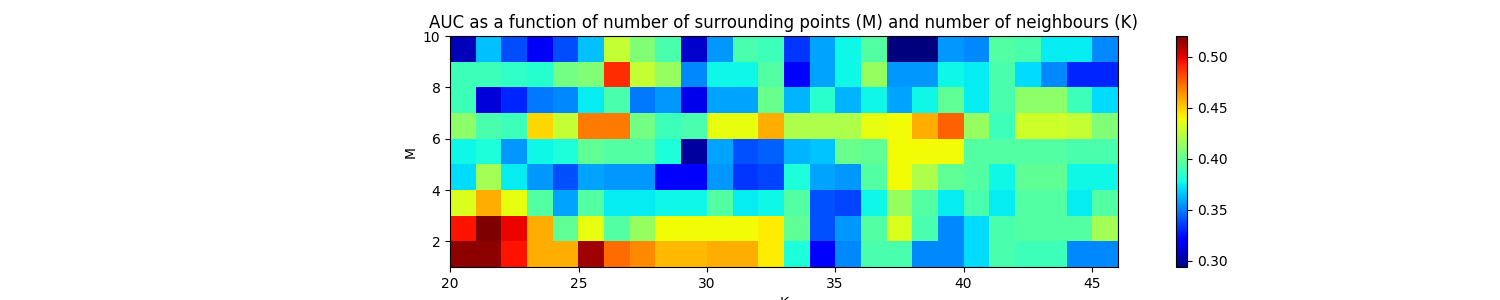

In [11]:
img = Image.open("/content/drive/My Drive/FlowPS/predictions_top30/auc.png")
img

## Scheme with TOP 40

In [17]:
%%R

system2("python3", c("/content/drive/My\\ Drive/FlowPS/flowps_new.py", 
                     "--train-file", "/content/drive/My\\ Drive/FlowPS/change_data/GSE37946.csv", 
                     "--out-dir", "/content/drive/My\\ Drive/FlowPS/predictions_top40/", 
                     "--features", "/content/drive/My\\ Drive/FlowPS/core_markers/GSE37946/GSE37946_top40.pickle",
                     "--min-neighbours", 20, "--max-neighbours", 45,
                     "--min-surround", 1, "--max-surround", 14), 
                      stderr = "/content/drive/My Drive/FlowPS/predictions_top40/err.txt")

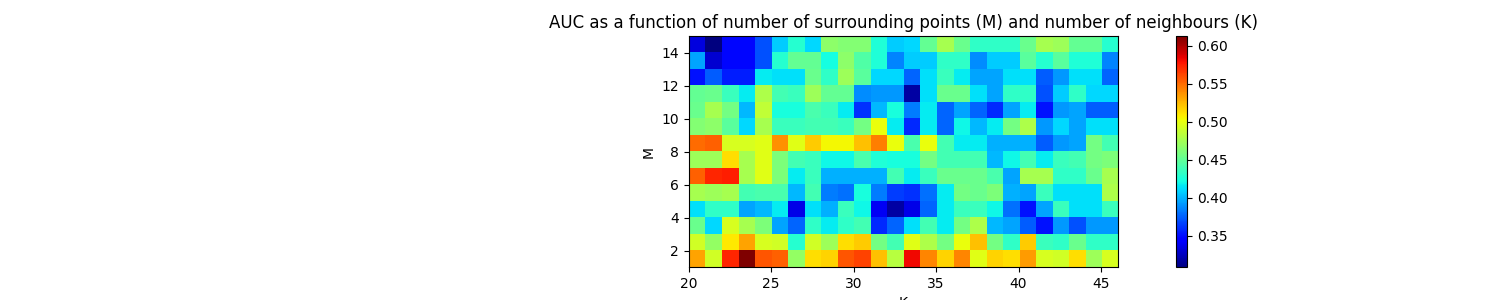

In [18]:
img = Image.open("/content/drive/My Drive/FlowPS/predictions_top40/auc.png")
img

## Scheme with TOP 50

In [4]:
%%R

system2("python3", c("/content/drive/My\\ Drive/FlowPS/flowps_new.py", 
                     "--train-file", "/content/drive/My\\ Drive/FlowPS/change_data/GSE37946.csv", 
                     "--out-dir", "/content/drive/My\\ Drive/FlowPS/predictions_top50/", 
                     "--features", "/content/drive/My\\ Drive/FlowPS/core_markers/GSE37946/GSE37946_top50.pickle",
                     "--min-neighbours", 20, "--max-neighbours", 45,
                     "--min-surround", 1, "--max-surround", 18), 
                      stderr = "/content/drive/My Drive/FlowPS/predictions_top50/err.txt")

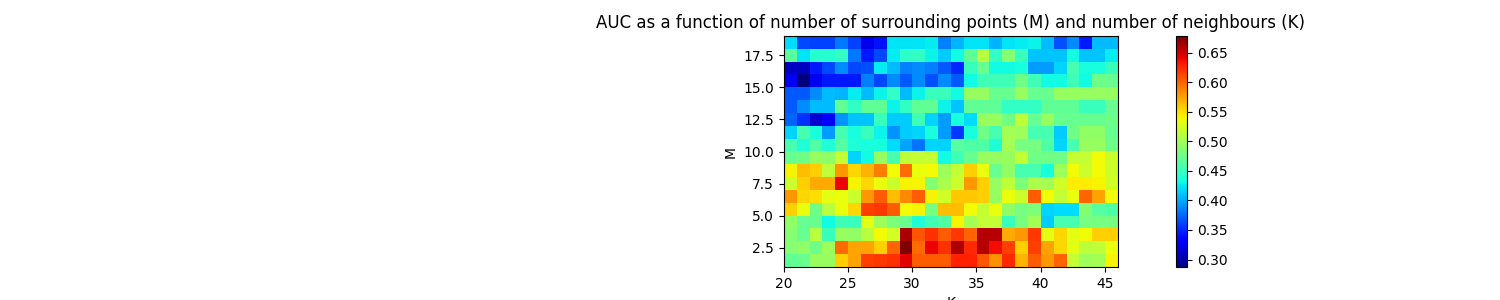

In [6]:
img = Image.open("/content/drive/My Drive/FlowPS/predictions_top50/auc.png")
img

# GSE76360


## Scheme with TOP 50

In [29]:
%%R

system2("python3", c("/content/drive/My\\ Drive/FlowPS/flowps_new.py", 
                     "--train-file", "/content/drive/My\\ Drive/FlowPS/change_data/GSE76360.csv", 
                     "--out-dir", "/content/drive/My\\ Drive/FlowPS/predictions/GSE76360/predictions_top50/", 
                     "--features", "/content/drive/My\\ Drive/FlowPS/core_markers/GSE76360/GSE76360_top50.pickle",
                     "--min-neighbours", 30, "--max-neighbours", 40,
                     "--min-surround", 1, "--max-surround", 6), 
                      stderr = "/content/drive/My Drive/FlowPS/predictions/GSE76360/predictions_top50/err.txt")

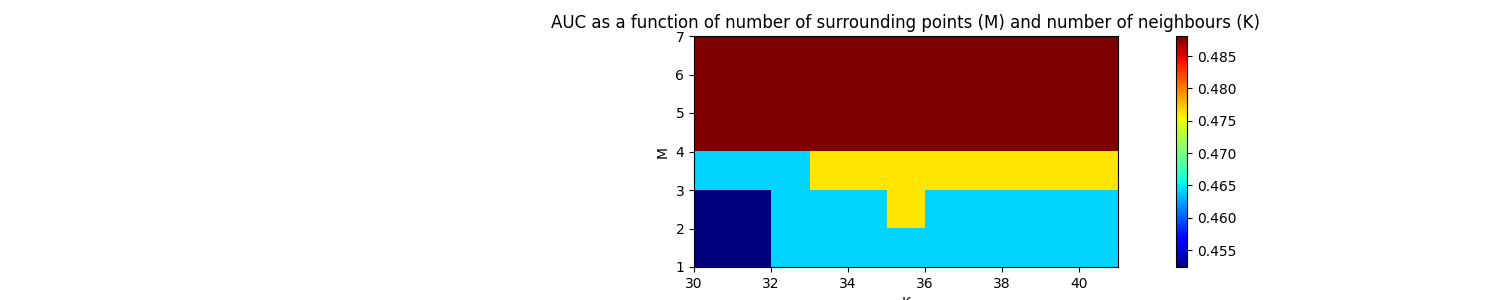

In [32]:
img = Image.open("/content/drive/My Drive/FlowPS/predictions/GSE76360/predictions_top50/auc.png")
img

## Scheme with TOP 75

In [33]:
%%R

system2("python3", c("/content/drive/My\\ Drive/FlowPS/flowps_new.py", 
                     "--train-file", "/content/drive/My\\ Drive/FlowPS/change_data/GSE76360.csv", 
                     "--out-dir", "/content/drive/My\\ Drive/FlowPS/predictions/GSE76360/predictions_top75/", 
                     "--features", "/content/drive/My\\ Drive/FlowPS/core_markers/GSE76360/GSE76360_top75.pickle",
                     "--min-neighbours", 30, "--max-neighbours", 40,
                     "--min-surround", 1, "--max-surround", 9), 
                      stderr = "/content/drive/My Drive/FlowPS/predictions/GSE76360/predictions_top75/err.txt")

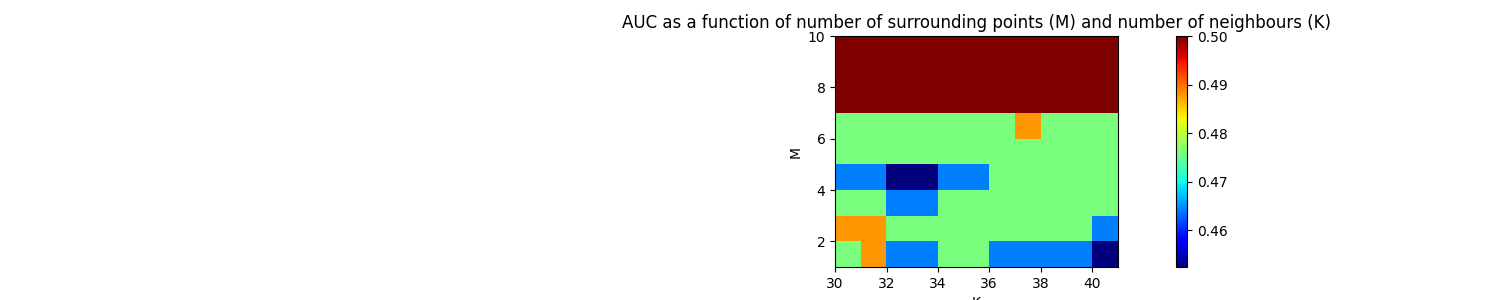

In [34]:
img = Image.open("/content/drive/My Drive/FlowPS/predictions/GSE76360/predictions_top75/auc.png")
img

## Scheme with TOP 100

In [27]:
%%R

system2("python3", c("/content/drive/My\\ Drive/FlowPS/flowps_new.py", 
                     "--train-file", "/content/drive/My\\ Drive/FlowPS/change_data/GSE76360.csv", 
                     "--out-dir", "/content/drive/My\\ Drive/FlowPS/predictions/GSE76360/predictions_top100/", 
                     "--features", "/content/drive/My\\ Drive/FlowPS/core_markers/GSE76360/GSE76360_top100.pickle",
                     "--min-neighbours", 30, "--max-neighbours", 45,
                     "--min-surround", 1, "--max-surround", 11), 
                      stderr = "/content/drive/My Drive/FlowPS/predictions/GSE76360/predictions_top100/err.txt")

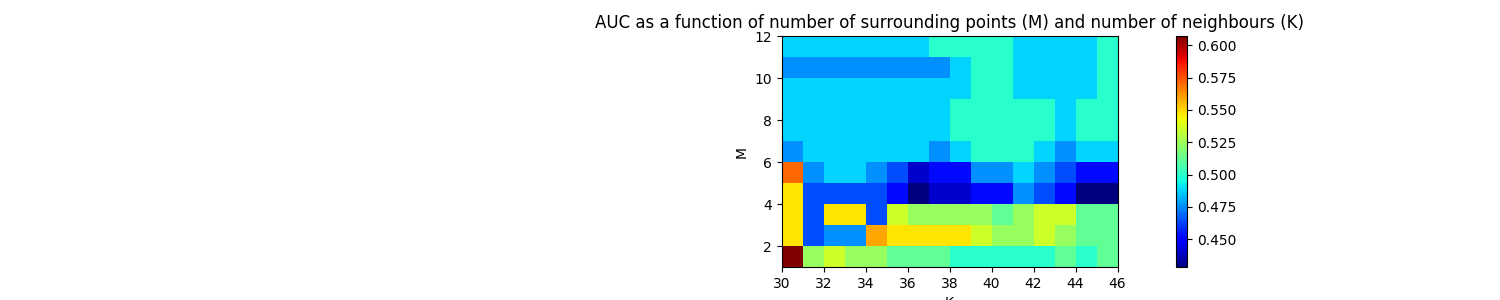

In [28]:
img = Image.open("/content/drive/My Drive/FlowPS/predictions/GSE76360/predictions_top100/auc.png")
img